# Matrikel-Nr: 2235021

# **Cloud Segmentation**

Dataset: https://www.kaggle.com/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images/code

## **Imports**

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

C:\Users\janmu\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Check for GPU**

In [2]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA is available:", cuda_available)

# Get the number of available GPUs
if cuda_available:
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs:", num_gpus)

# Print the current device name
current_device = torch.cuda.current_device() if cuda_available else "CPU"
print("Current device:", current_device)

# Print device properties
if cuda_available:
    print("Device name:", torch.cuda.get_device_name(current_device))
    print("CUDA version:", torch.version.cuda)


CUDA is available: True
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA version: 12.1


## **Load Dataset**
#### Initialization:
The dataset is initialized by passing directories (r_dir, g_dir, b_dir, nir_dir, gt_dir) containing different spectral band images (Red, Green, Blue, Near-Infrared) and ground truth masks.
For each file in the r_dir (red band directory), the dataset creates a dictionary combining file paths for other spectral bands and the corresponding ground truth mask.

#### Data Loading:
getitem(self, idx) is the method used to retrieve an item from the dataset.
open_as_array() opens image files as arrays, stacking them together into a 3D array (RGB+NIR if enabled).
open_mask() opens the ground truth mask and encodes it as a binary mask with values 0 and 1.
The data returned by getitem is a tuple (x, y) containing the input image tensor x and the corresponding ground truth mask tensor y.

#### Data Representation:
Images are represented as PyTorch tensors. open_as_array reads image bands and constructs the input tensor. If include_nir=True, it includes the Near-Infrared band.
Pixel values are normalized to the range [0, 1] by dividing by the maximum pixel value of the data type.
Ground truth masks are represented as tensors with values 0 and 1 (binary segmentation).

#### Data Access:
open_as_pil() method converts the loaded image back to a PIL image.
repr() provides a string representation of the dataset indicating the number of files in the dataset.

In [3]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in the red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        # Combine file paths for different spectral bands into a dictionary
        files = {'red': r_file, 
                 'green': g_dir / r_file.name.replace('red', 'green'),
                 'blue': b_dir / r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir / r_file.name.replace('red', 'nir'),
                 'gt': gt_dir / r_file.name.replace('red', 'gt')}
        return files
                                       
    def __len__(self):
        # Return the number of files in the dataset
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        # Open image files as arrays, optionally including NIR channel
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))
    
        # Normalize pixel values
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    
    def open_mask(self, idx, add_dims=False):
        # Open ground truth mask as an array
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        # Get an item from the dataset (image and mask)
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        # Open an image as a PIL image
        arr = 256 * self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        # Return a string representation of the dataset
        s = 'Dataset class with {} files'.format(self.__len__())
        return s

In [4]:
base_path = Path('../data/clouds_dataset/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [5]:
x, y = data[1000]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

In [6]:
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=12)
valid_dl = DataLoader(valid_ds, batch_size=12)

## **Segmentation with Seg-Net**

### **Main differences U-Net & Seg-Net**
#### **Architecture:**
- **U-Net:** Encoder-decoder with skip connections.
- **SegNet:** Reverse encoder-decoder without skip connections.

#### **Skip Connections:**
- **U-Net:** Utilizes skip connections to preserve spatial information.
- **SegNet:** Doesn't employ skip connections between encoder and decoder.

#### **Complexity:**
- **U-Net:** More complex with skip connections, often more parameters.
- **SegNet:** Simpler architecture with fewer parameters.

![Example Image](https://www.researchgate.net/profile/Joseph_Antony3/publication/335664770/figure/fig1/AS:800189904343041@1567791548600/Illustration-of-Segnet-architecture-with-the-input-image-and-the-final-expected-output.jpg "Seg-Net Architecture")

### **Define Seg-Net**

In [8]:
# Define SegNet architecture
class SegNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SegNet, self).__init__()

        # Encoder (downsampling)
        self.encoder_conv_1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.encoder_conv_2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.encoder_conv_3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.encoder_conv_4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        # Decoder (upsampling)
        self.decoder_conv_4 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.decoder_conv_3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.decoder_conv_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.decoder_conv_1 = nn.Conv2d(64, output_channels, kernel_size=3, padding=1)

        # Max pooling layers for indices saving in forward pass
        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=True)

        # Up-sample using indices from max pooling
        self.upsample = nn.MaxUnpool2d(2, stride=2)

    def forward(self, x):
        # Encoder
        x1 = torch.relu(self.encoder_conv_1(x))
        x, idx1 = self.maxpool(x1)

        x2 = torch.relu(self.encoder_conv_2(x))
        x, idx2 = self.maxpool(x2)

        x3 = torch.relu(self.encoder_conv_3(x))
        x, idx3 = self.maxpool(x3)

        x4 = torch.relu(self.encoder_conv_4(x))
        x, idx4 = self.maxpool(x4)

        # Decoder
        x = self.upsample(x, idx4)
        x = torch.relu(self.decoder_conv_4(x))

        x = self.upsample(x, idx3)
        x = torch.relu(self.decoder_conv_3(x))

        x = self.upsample(x, idx2)
        x = torch.relu(self.decoder_conv_2(x))

        x = self.upsample(x, idx1)
        x = self.decoder_conv_1(x)

        return x

# Set up the model
input_channels = 4  # Red, Green, Blue, NIR
output_channels = 2  # For binary classification (background and target)
segnet_model = SegNet(input_channels, output_channels)

### **Training Loop**

In [9]:
# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segnet_model.to(device)
print(f"Training on: {device}")

# Define loss function and optimizer AFTER moving the model to the device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(segnet_model.parameters(), lr=0.001)

# Training loop
num_epochs = 4
for epoch in range(num_epochs):
    segnet_model.train()
    running_loss = 0.0
    
    for i, data in enumerate(train_dl, 0):
        inputs, ground_truth = data

        # Move inputs and labels to GPU
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        ## calculate outpus
        outputs = segnet_model(inputs)
        ## calculate loss
        loss = criterion(outputs, ground_truth)
        
        # Backward pass and optimize
        ## computing gradients
        loss.backward()
        ## update models weights
        optimizer.step()

        running_loss += loss.item()
        
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                  f"Batch [{i + 1}/{len(train_dl)}], "
                  f"Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

print("Finished Training")

Training on: cuda
Epoch [1/4], Batch [100/500], Loss: 0.4285
Epoch [1/4], Batch [200/500], Loss: 0.3308
Epoch [1/4], Batch [300/500], Loss: 0.2649
Epoch [1/4], Batch [400/500], Loss: 0.2503
Epoch [1/4], Batch [500/500], Loss: 0.2460
Epoch [2/4], Batch [100/500], Loss: 0.2545
Epoch [2/4], Batch [200/500], Loss: 0.2434
Epoch [2/4], Batch [300/500], Loss: 0.1909
Epoch [2/4], Batch [400/500], Loss: 0.1917
Epoch [2/4], Batch [500/500], Loss: 0.2084
Epoch [3/4], Batch [100/500], Loss: 0.2449
Epoch [3/4], Batch [200/500], Loss: 0.1959
Epoch [3/4], Batch [300/500], Loss: 0.1517
Epoch [3/4], Batch [400/500], Loss: 0.1311
Epoch [3/4], Batch [500/500], Loss: 0.1737
Epoch [4/4], Batch [100/500], Loss: 0.1763
Epoch [4/4], Batch [200/500], Loss: 0.1494
Epoch [4/4], Batch [300/500], Loss: 0.1397
Epoch [4/4], Batch [400/500], Loss: 0.1262
Epoch [4/4], Batch [500/500], Loss: 0.1383
Finished Training


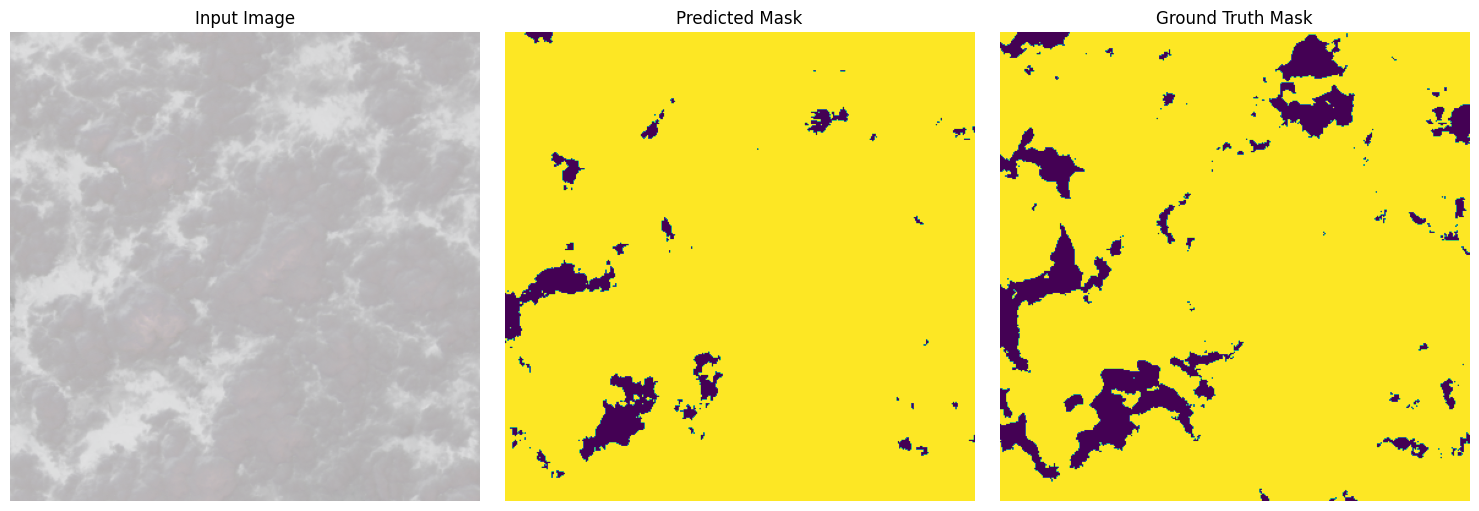

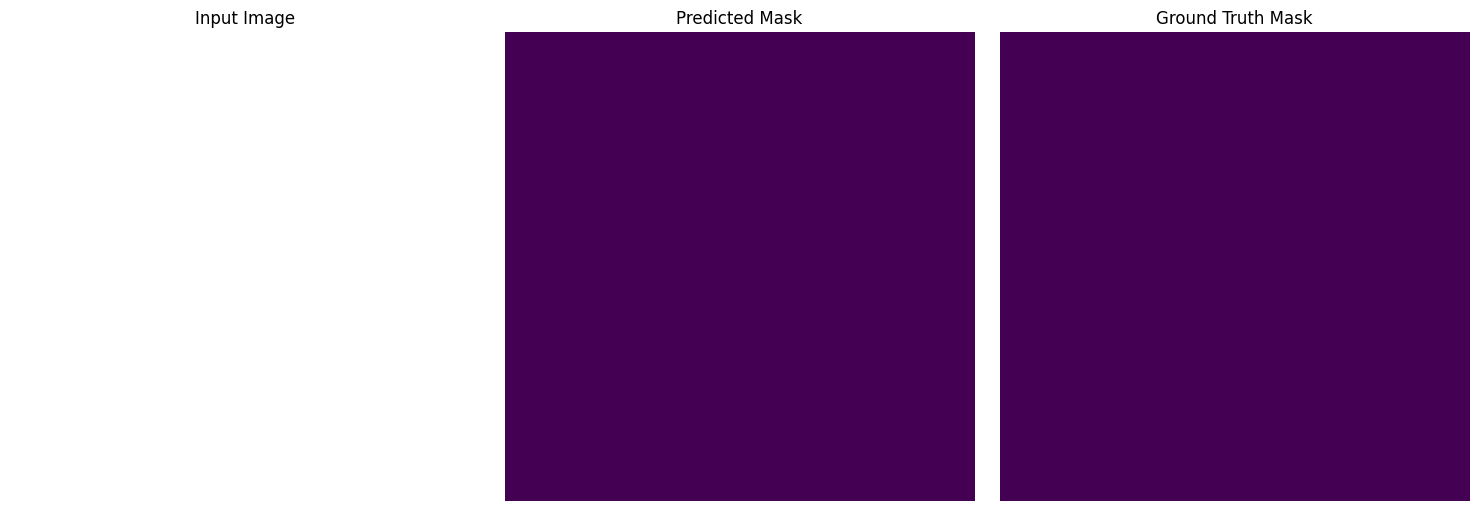

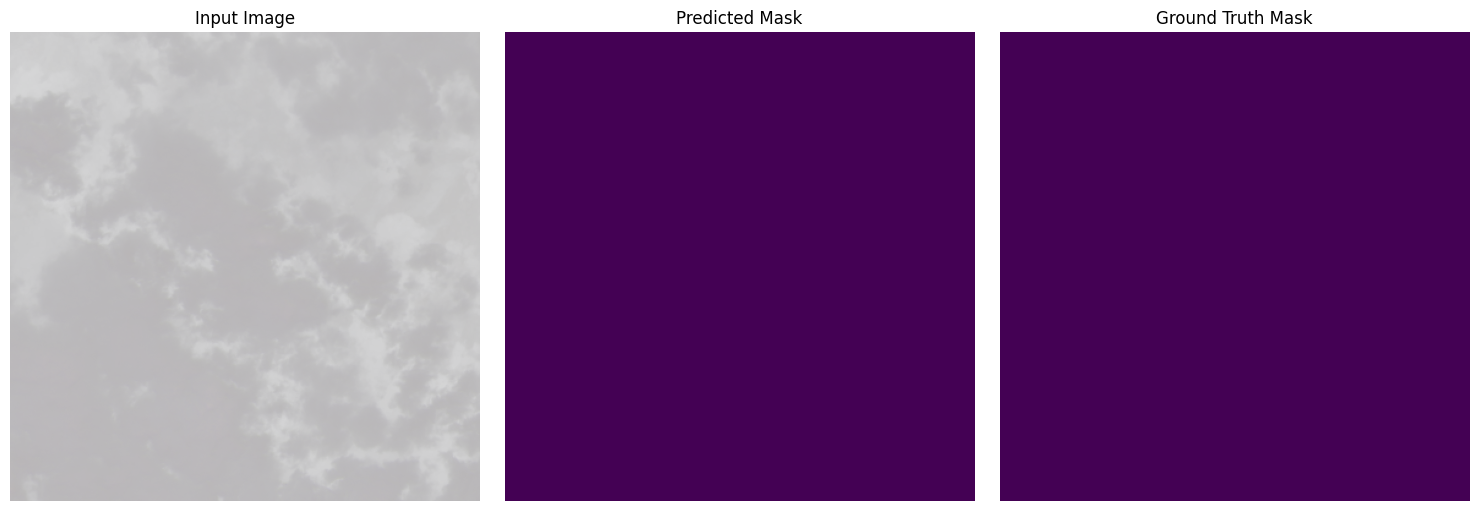

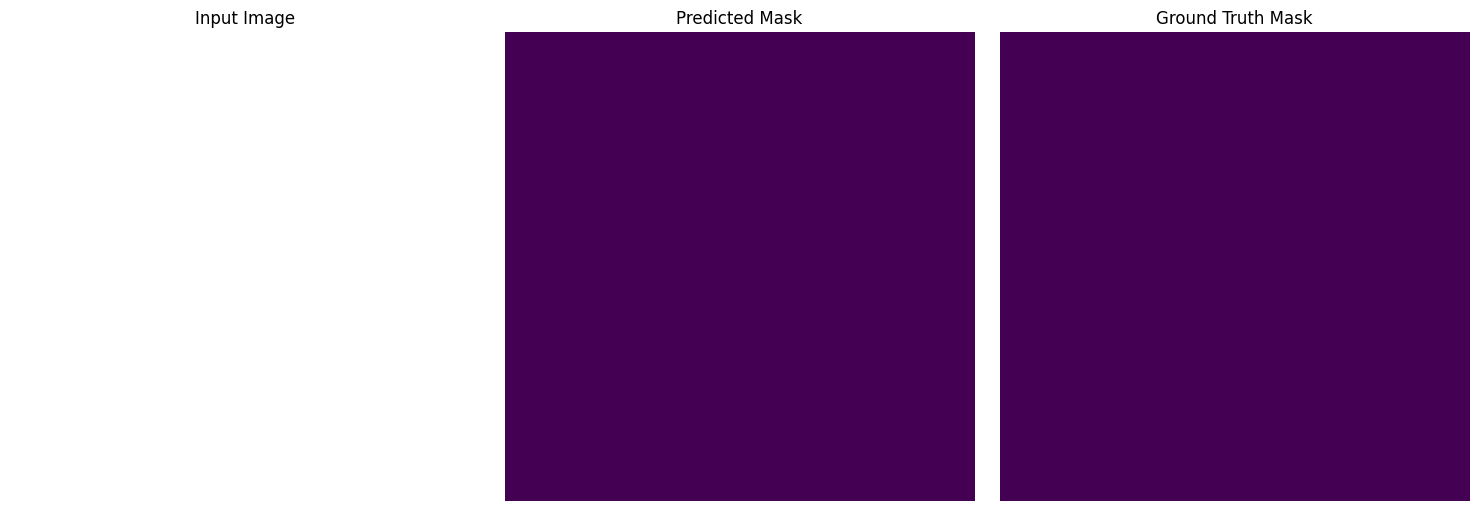

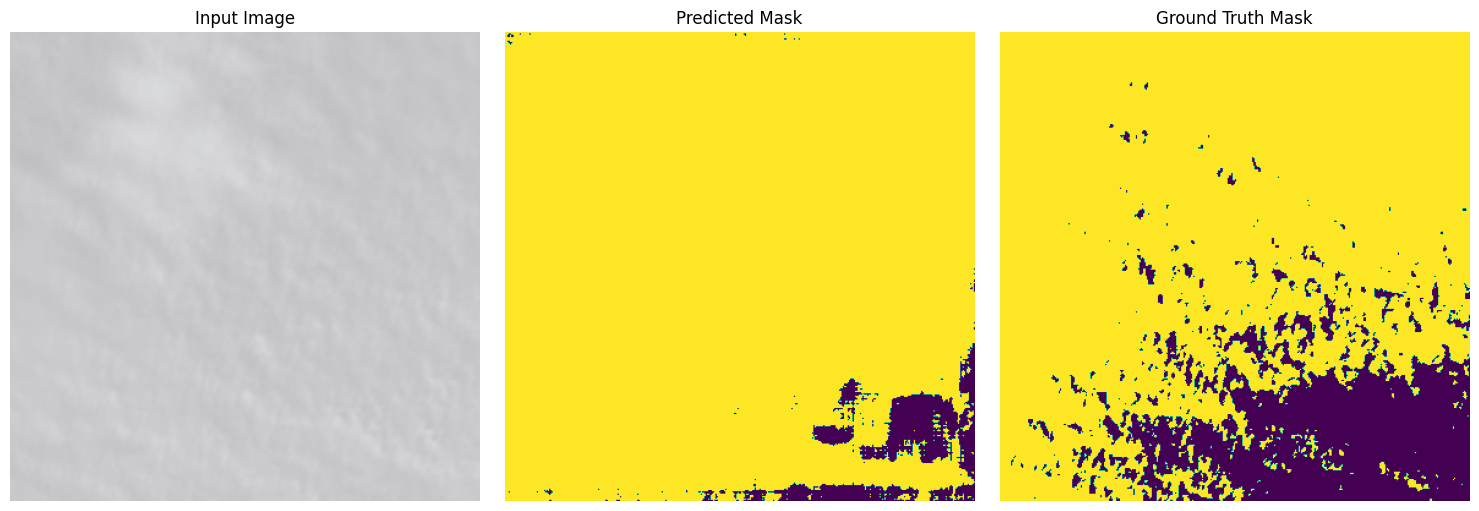

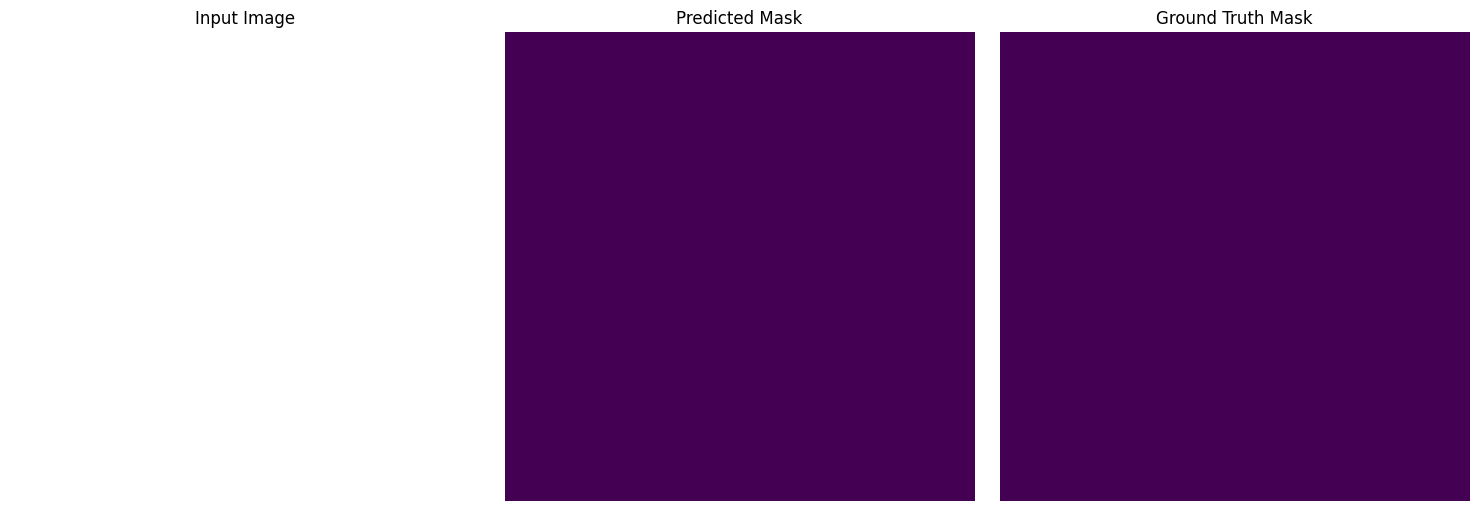

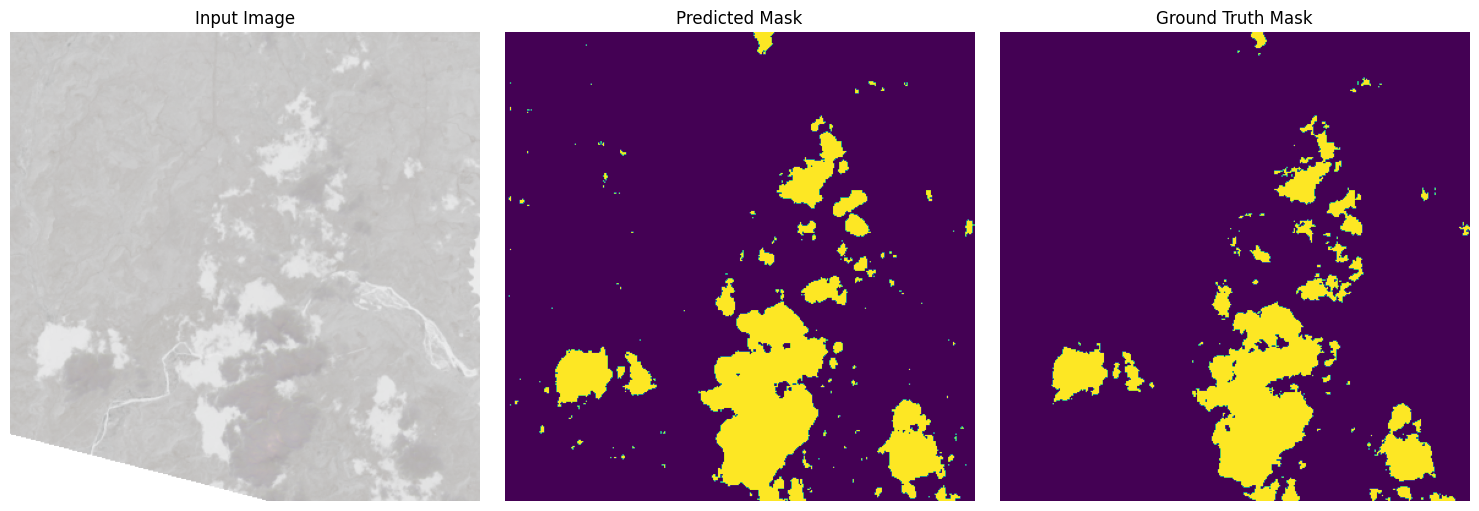

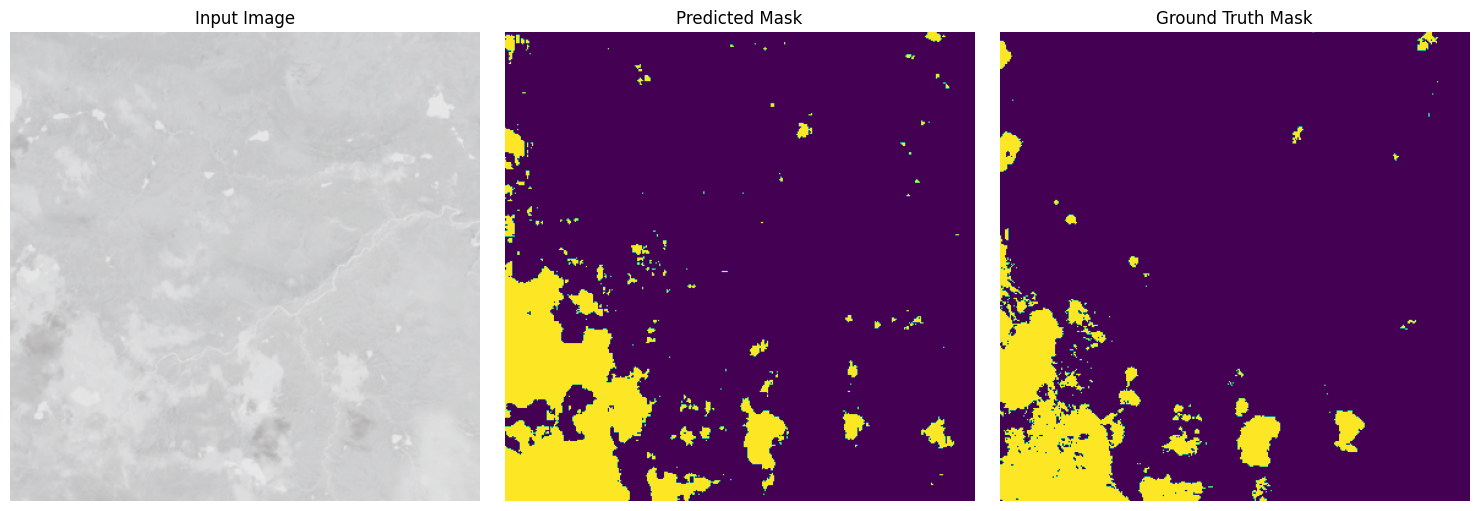

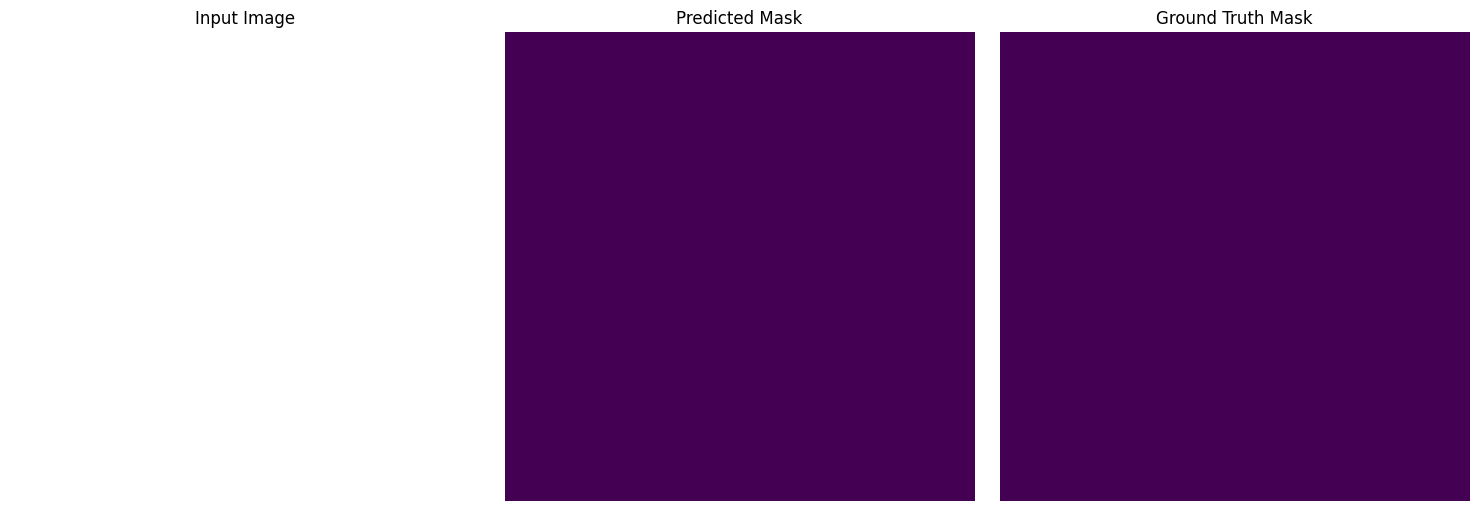

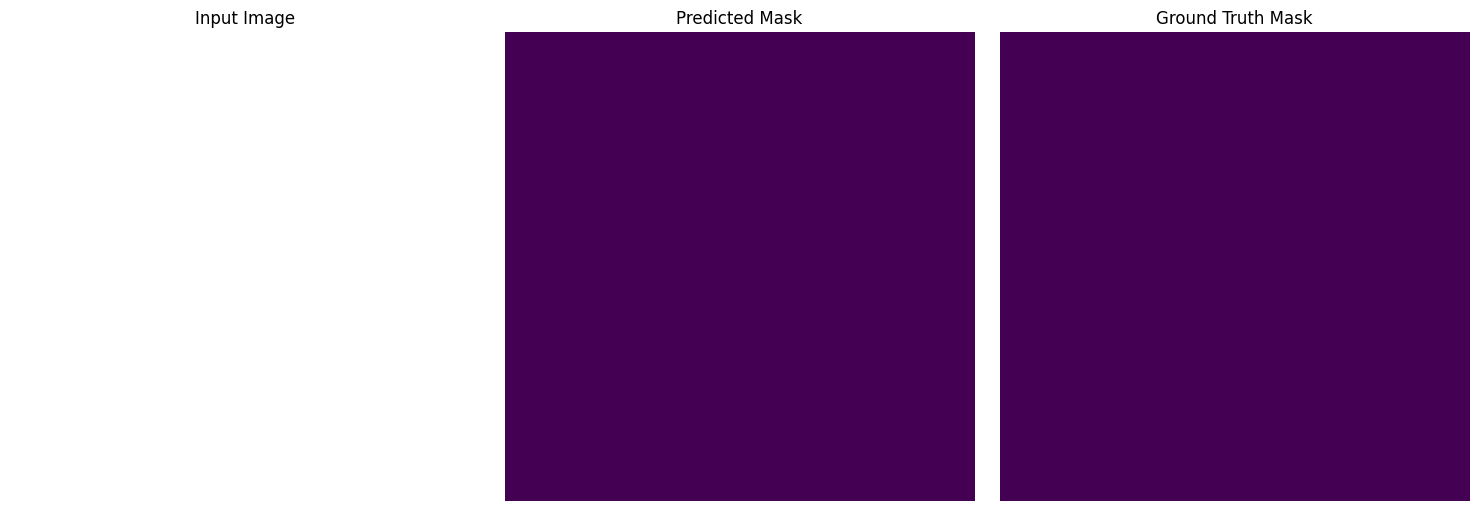

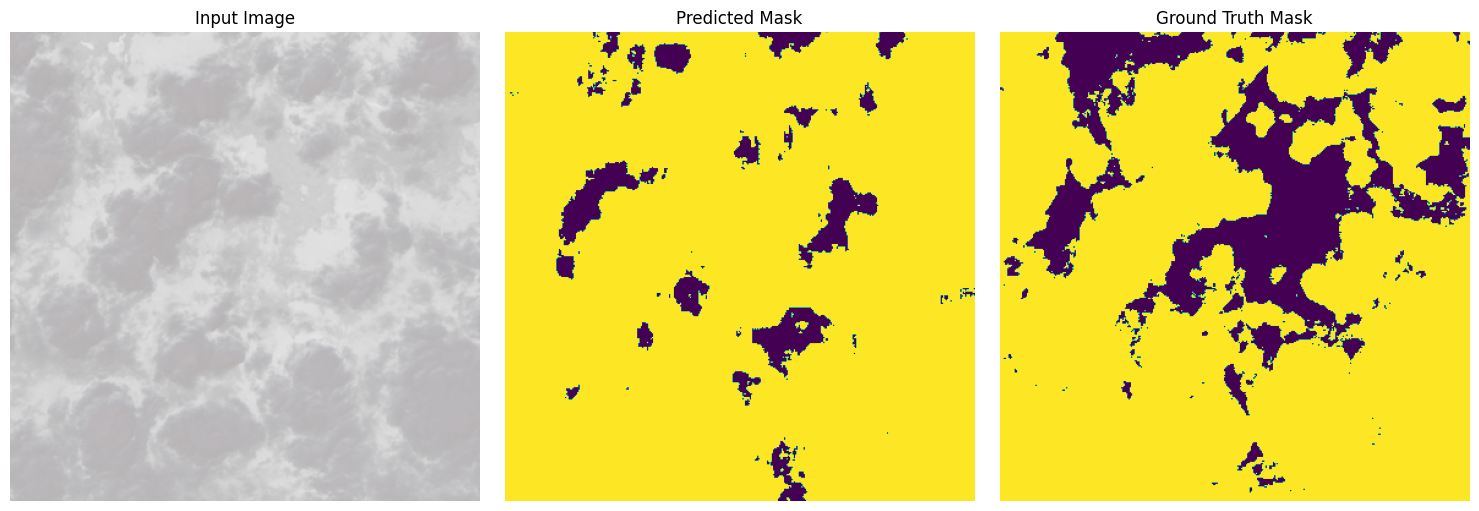

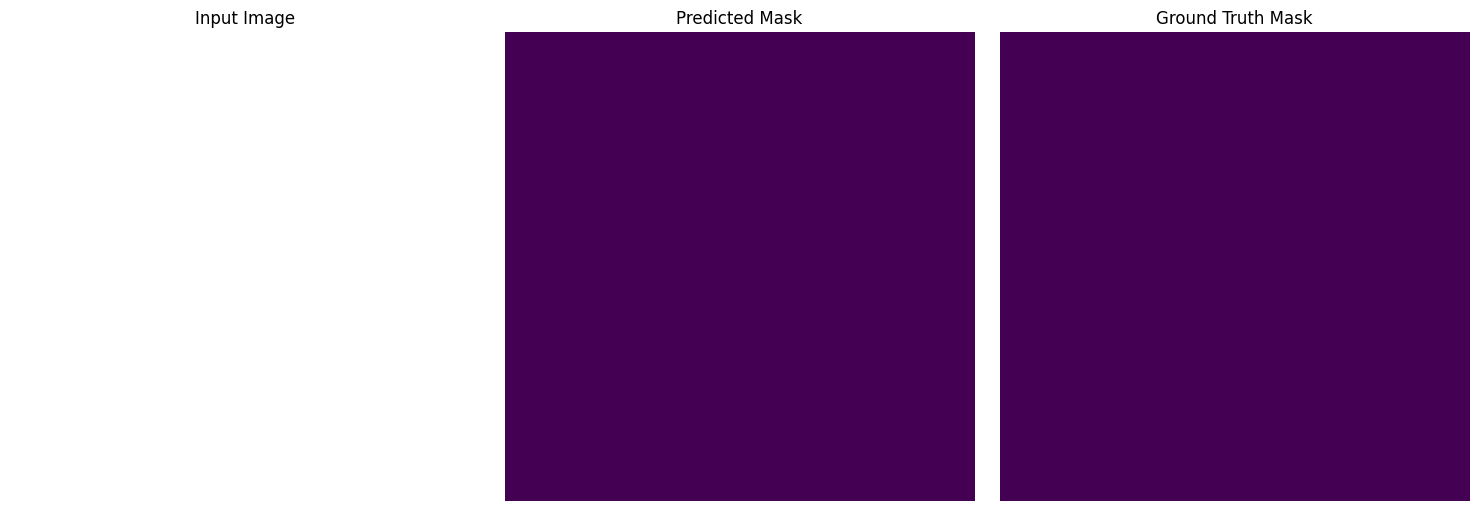

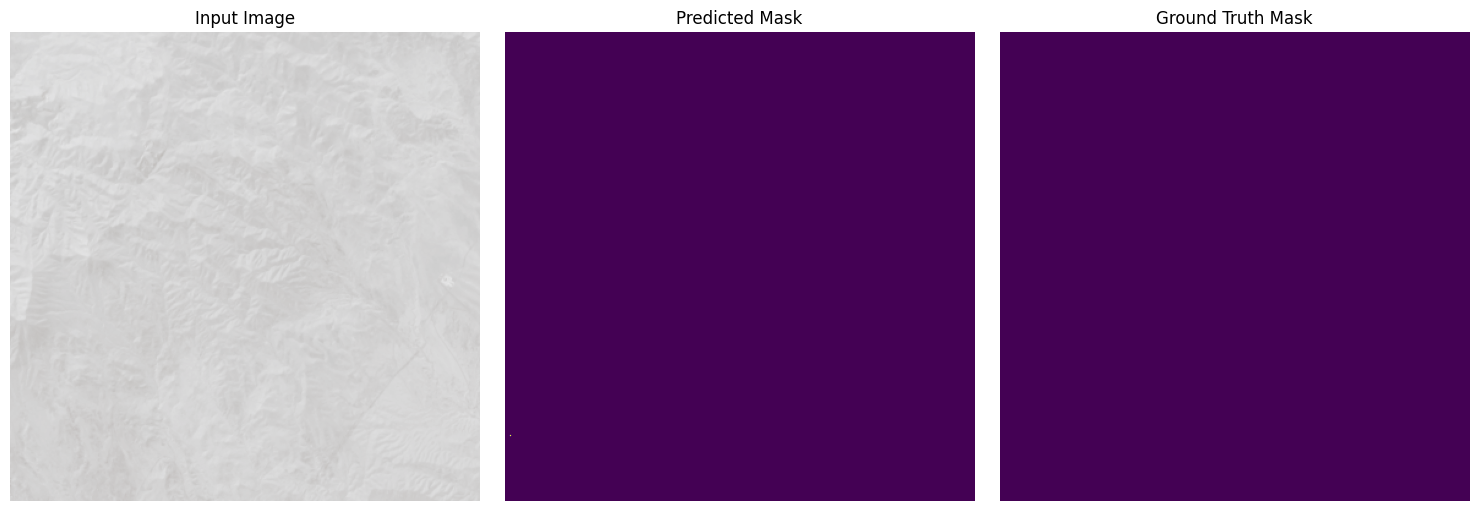

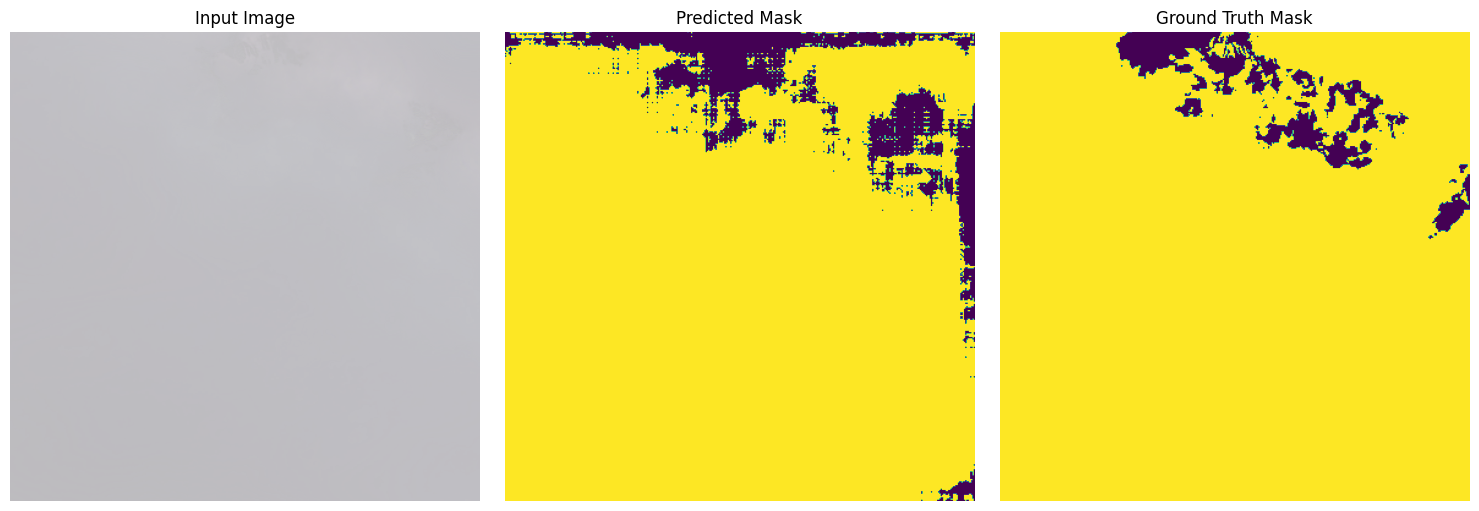

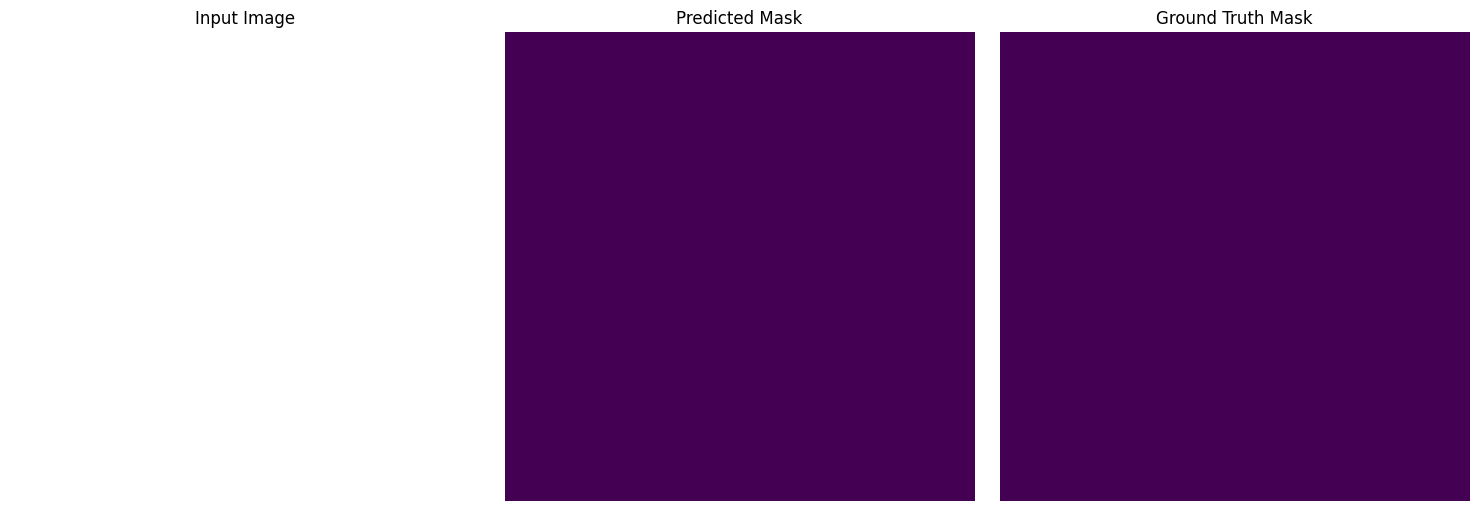

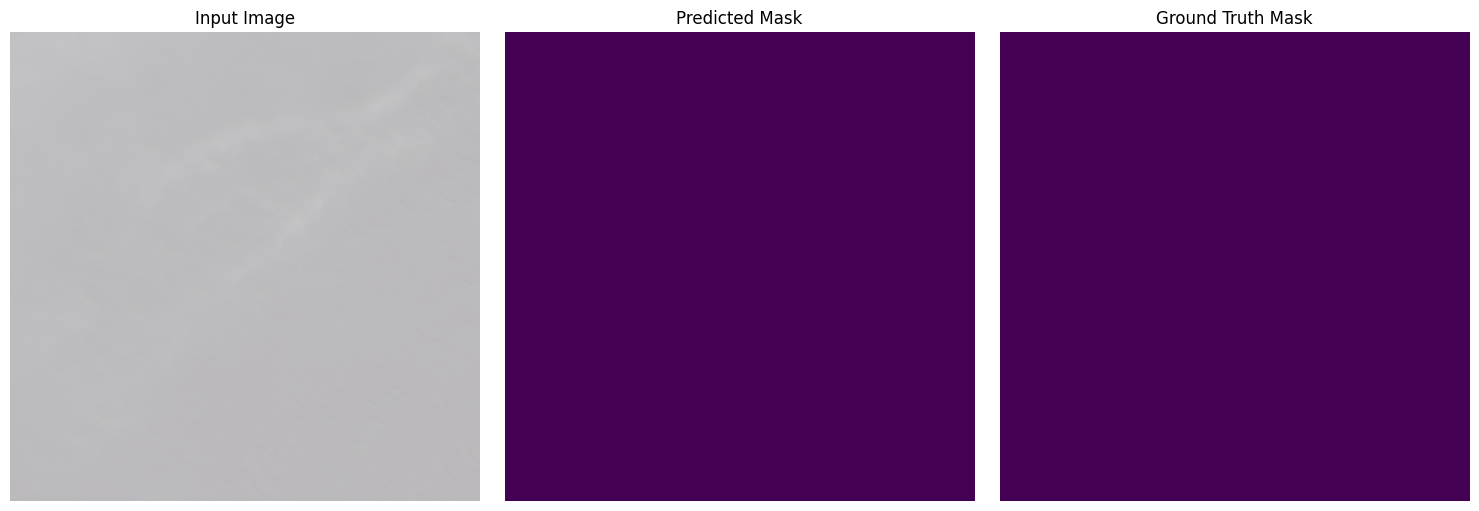

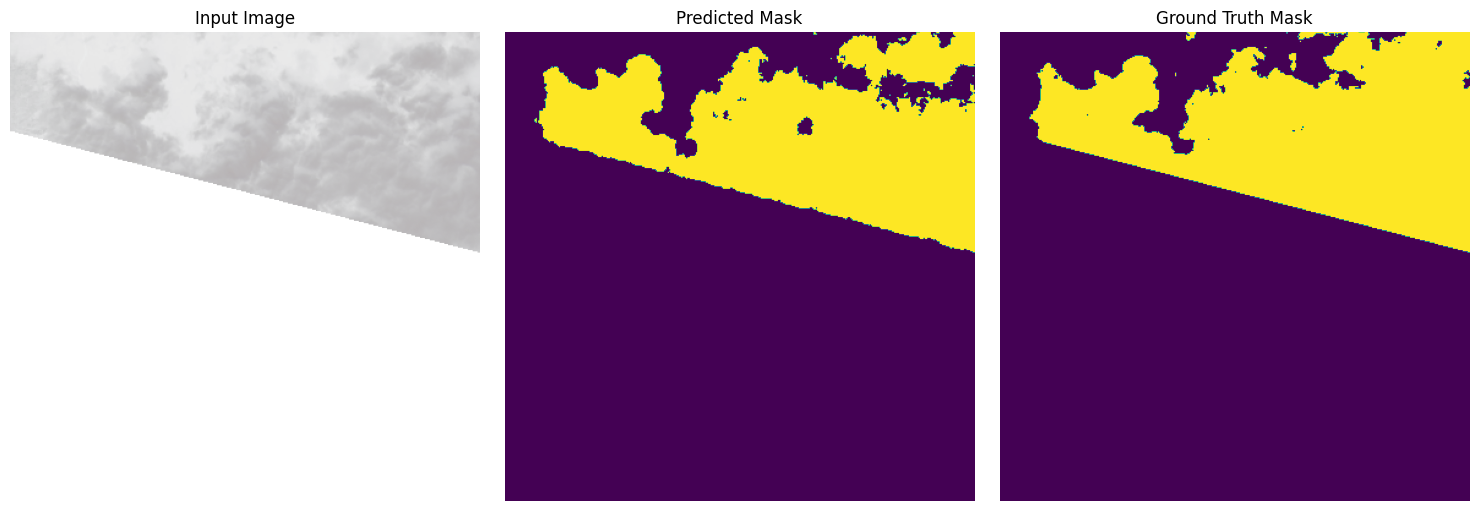

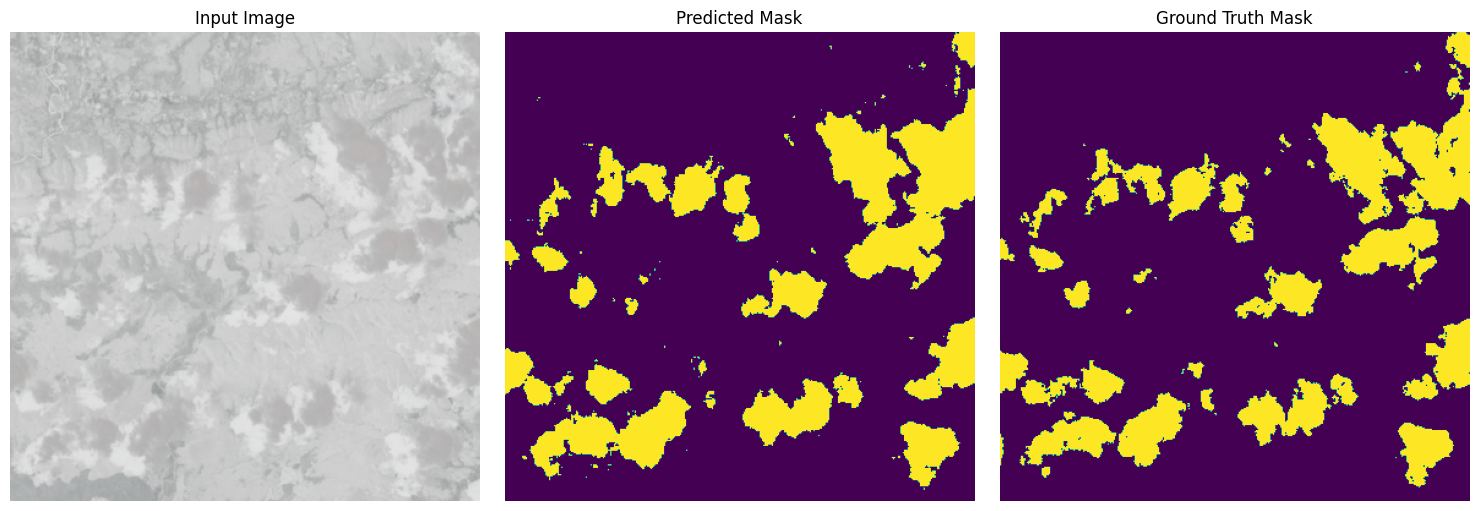

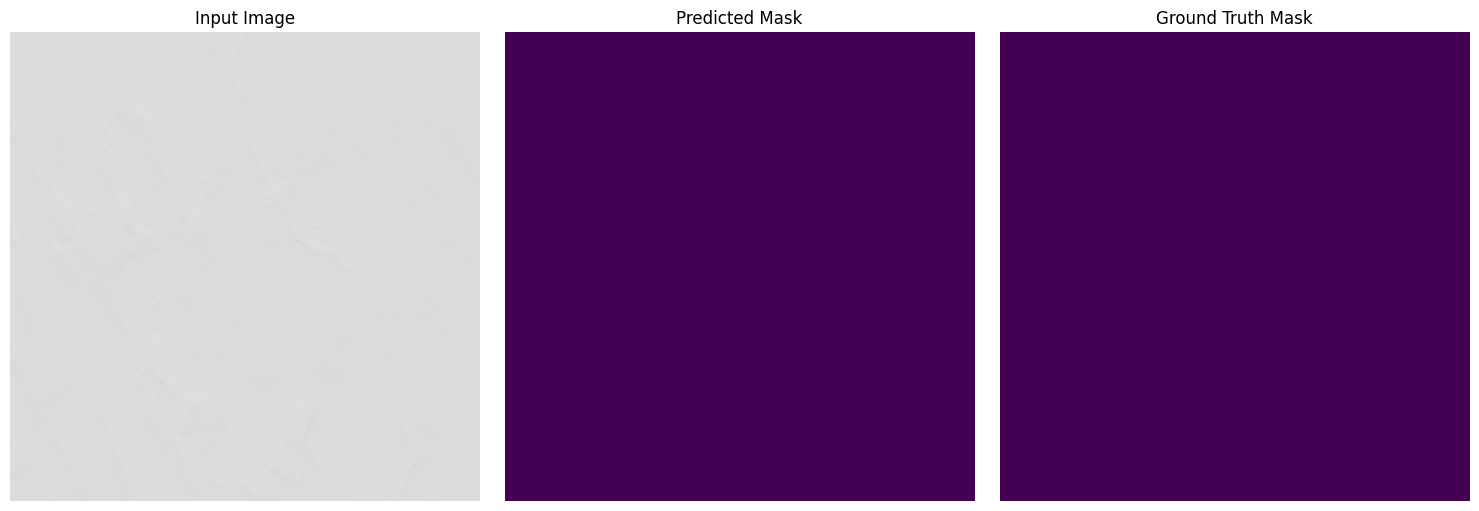

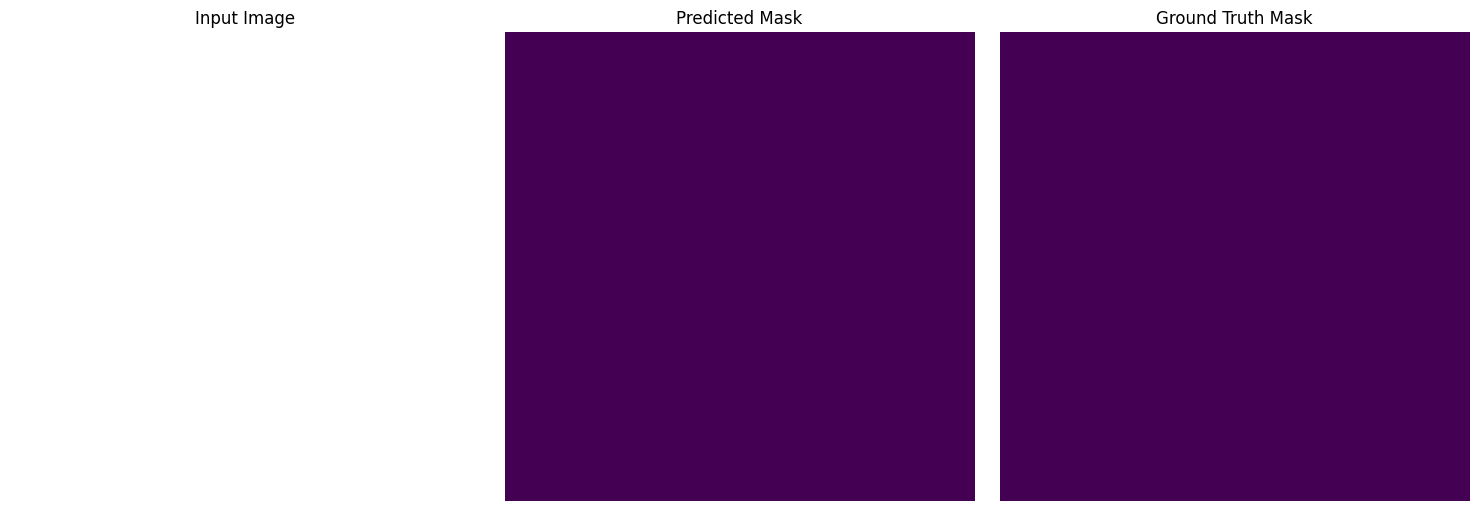

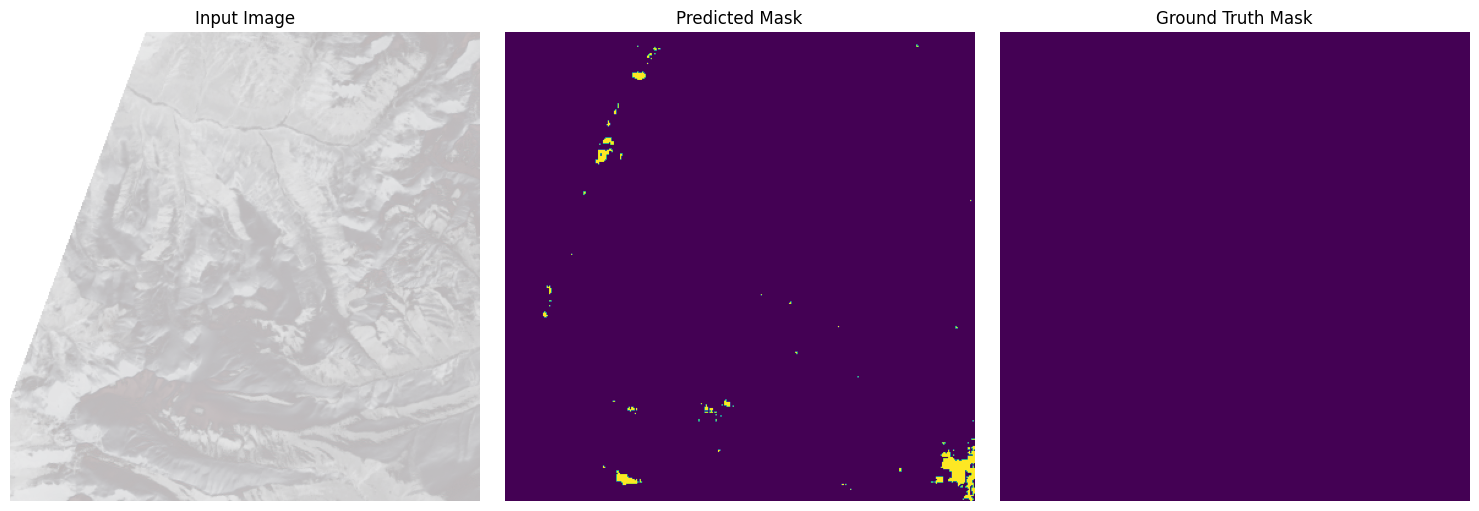

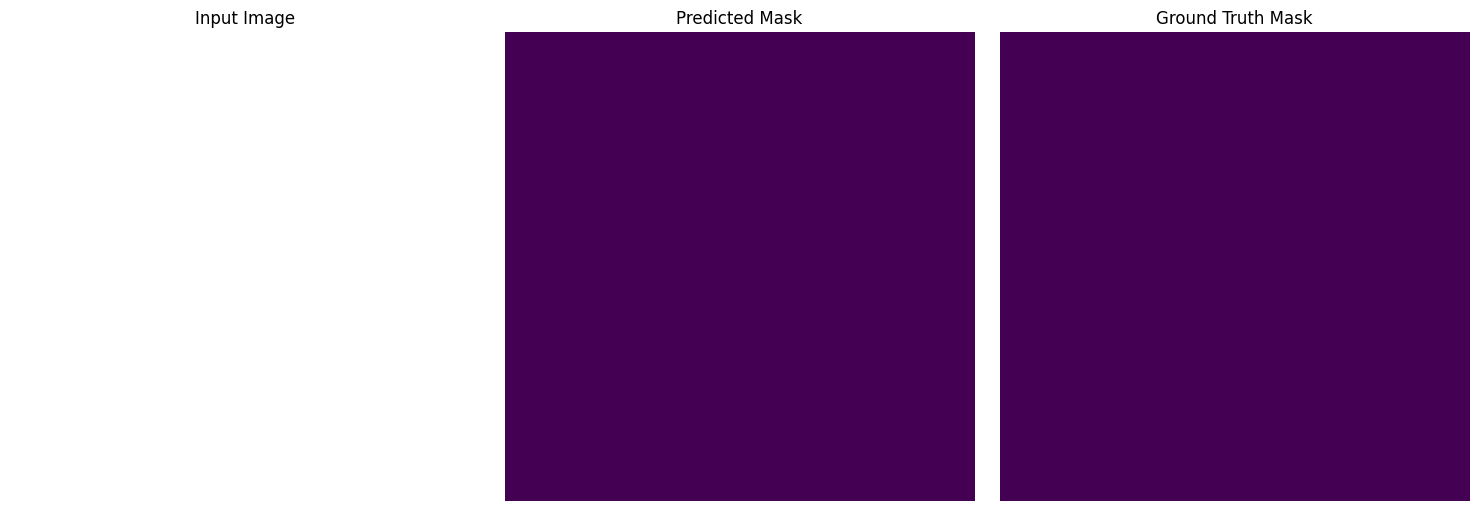

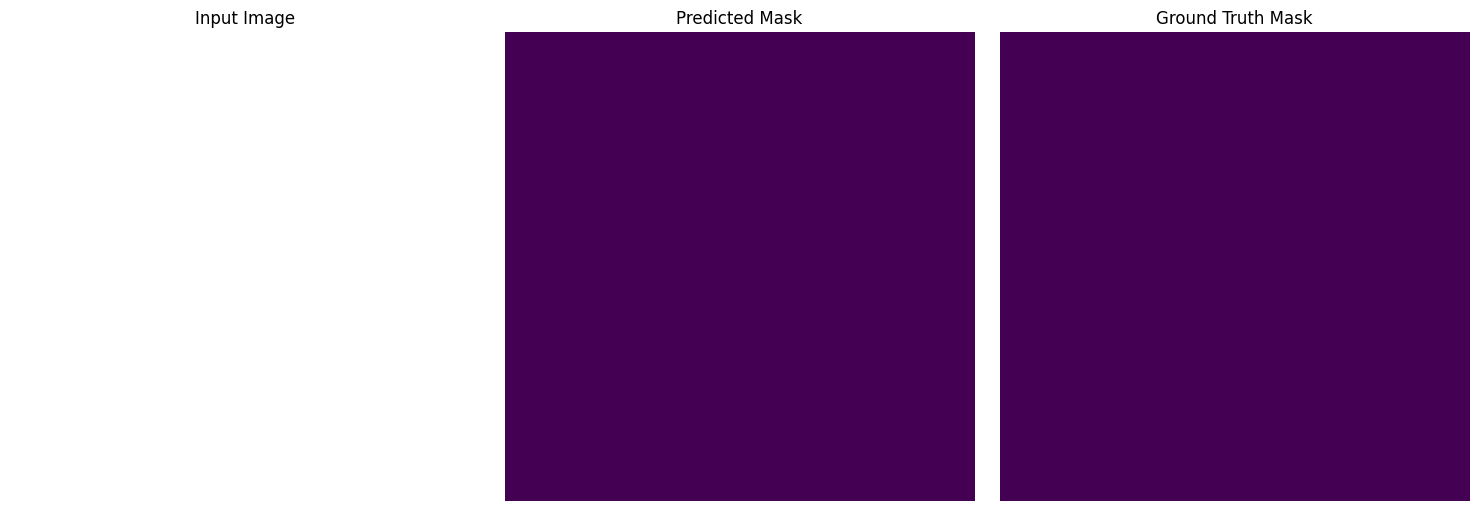

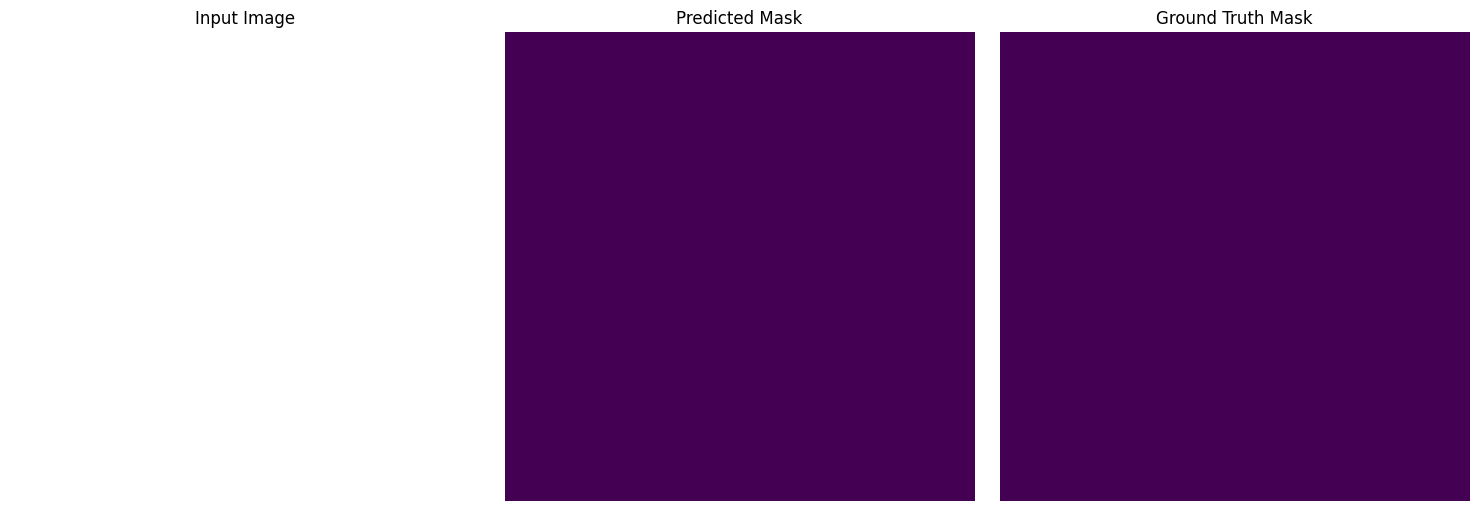

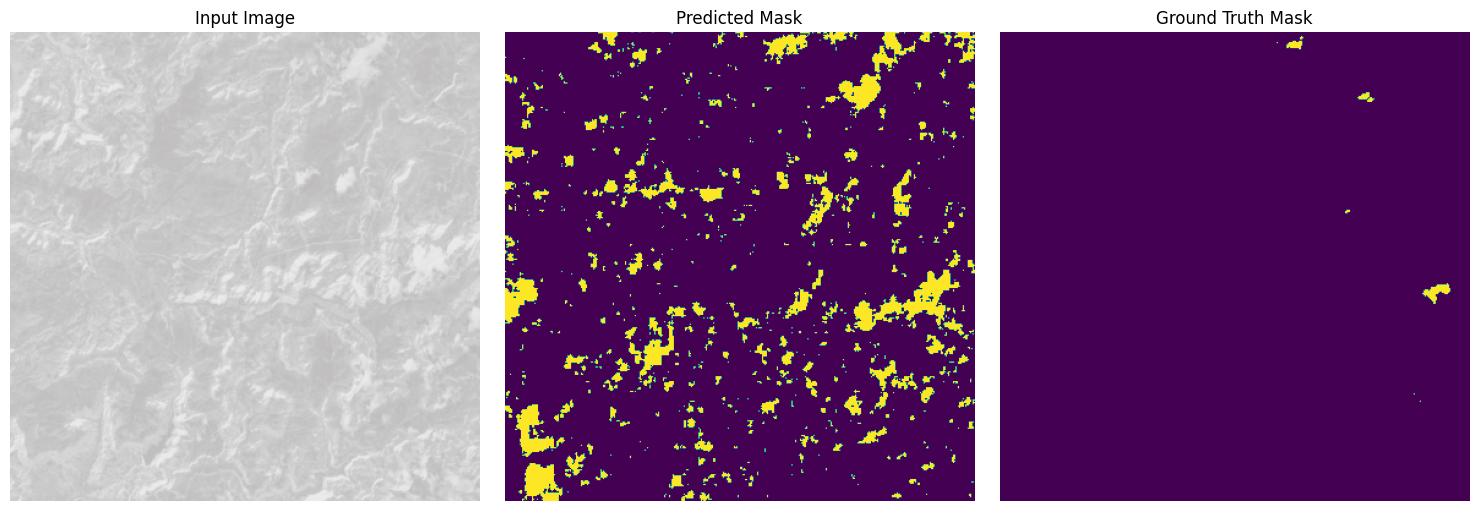

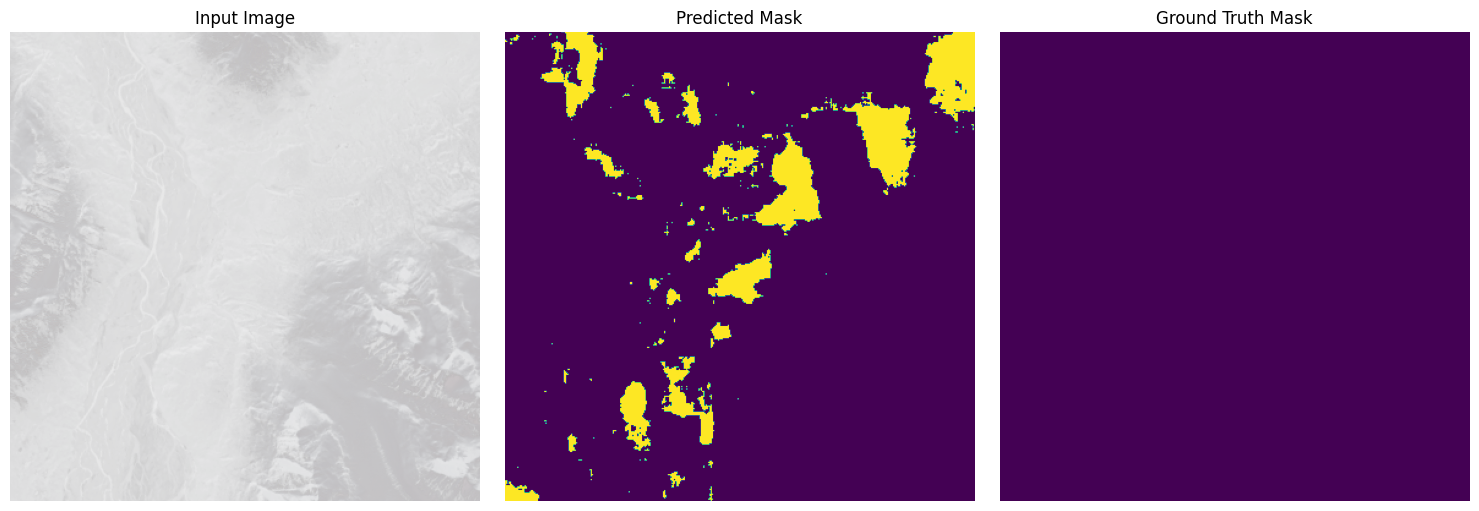

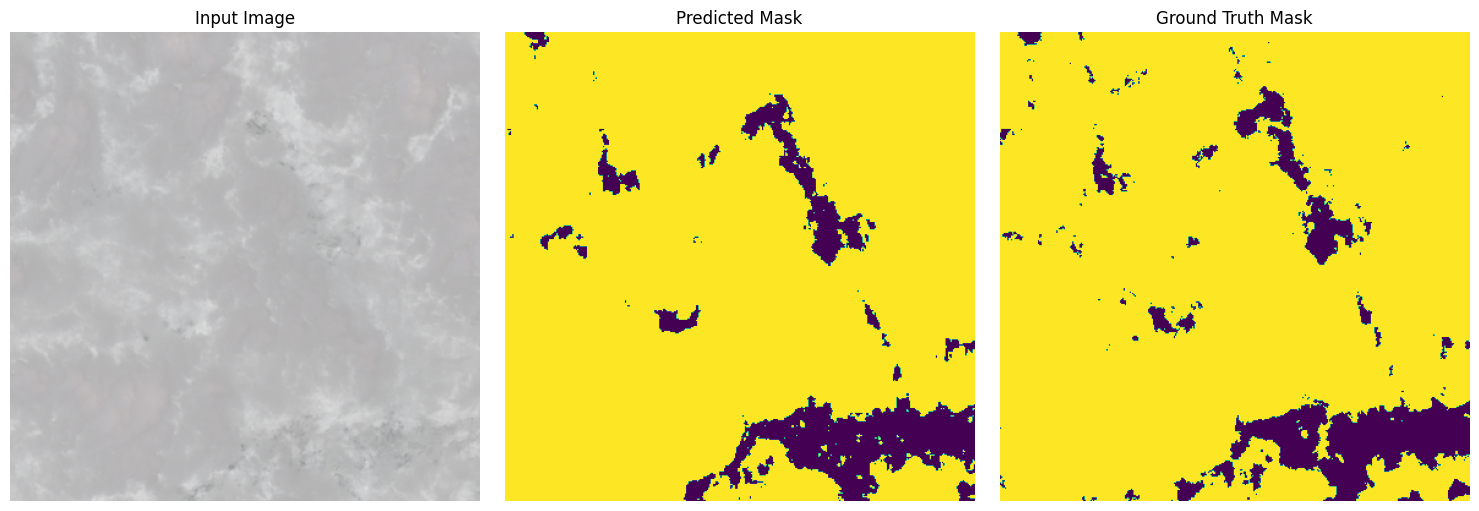

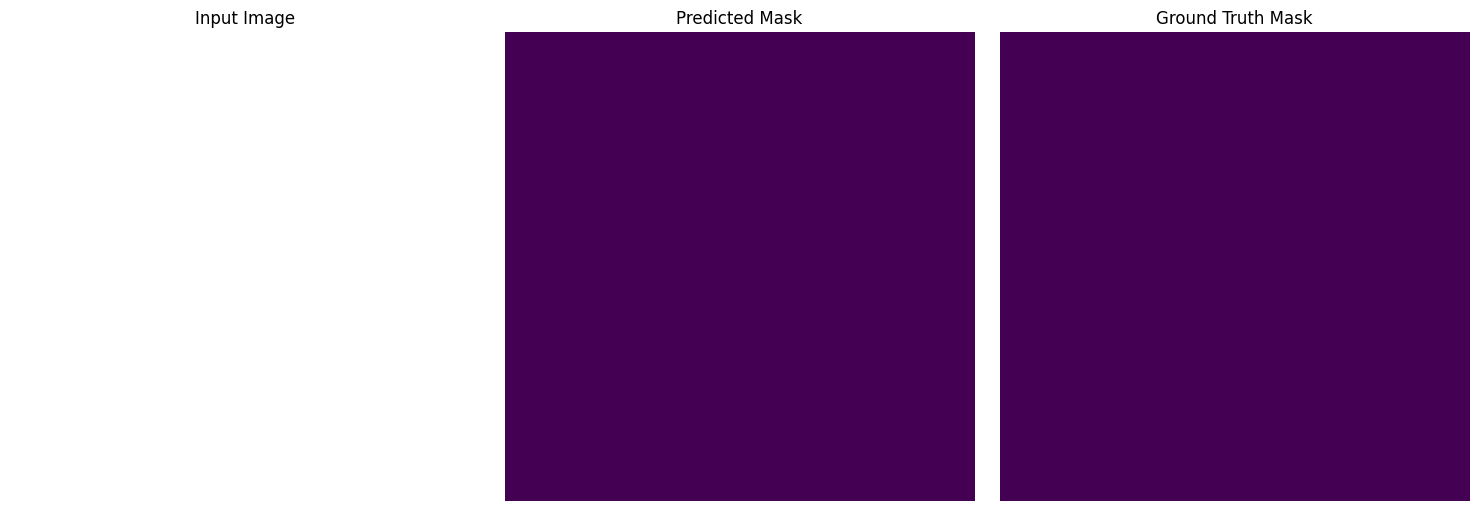

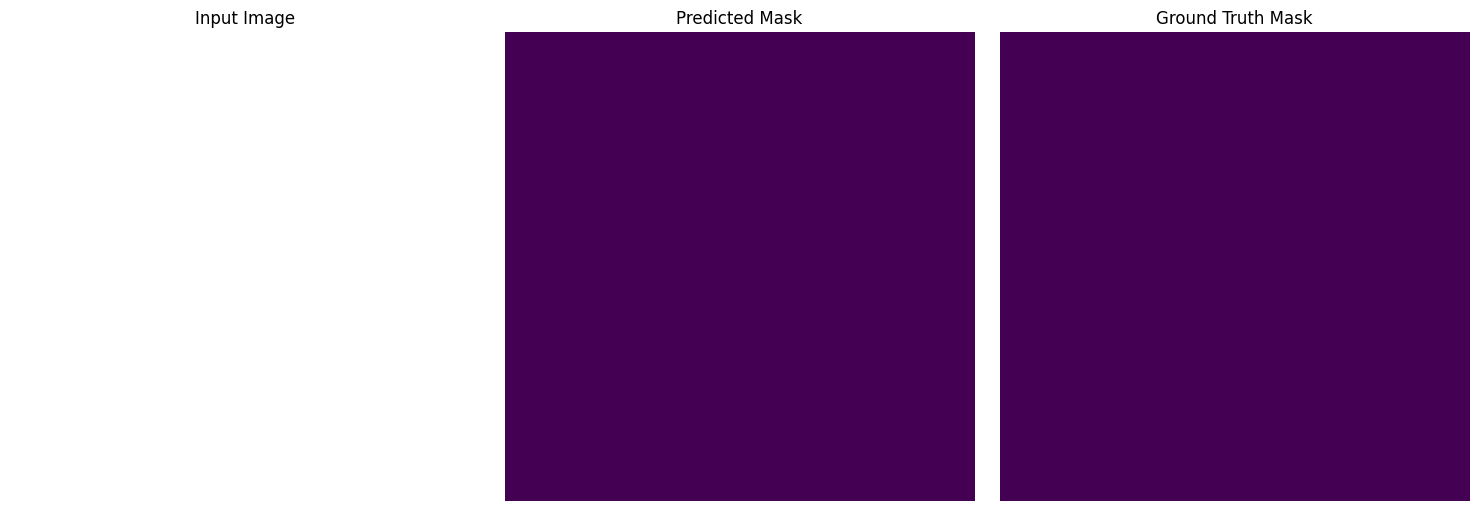

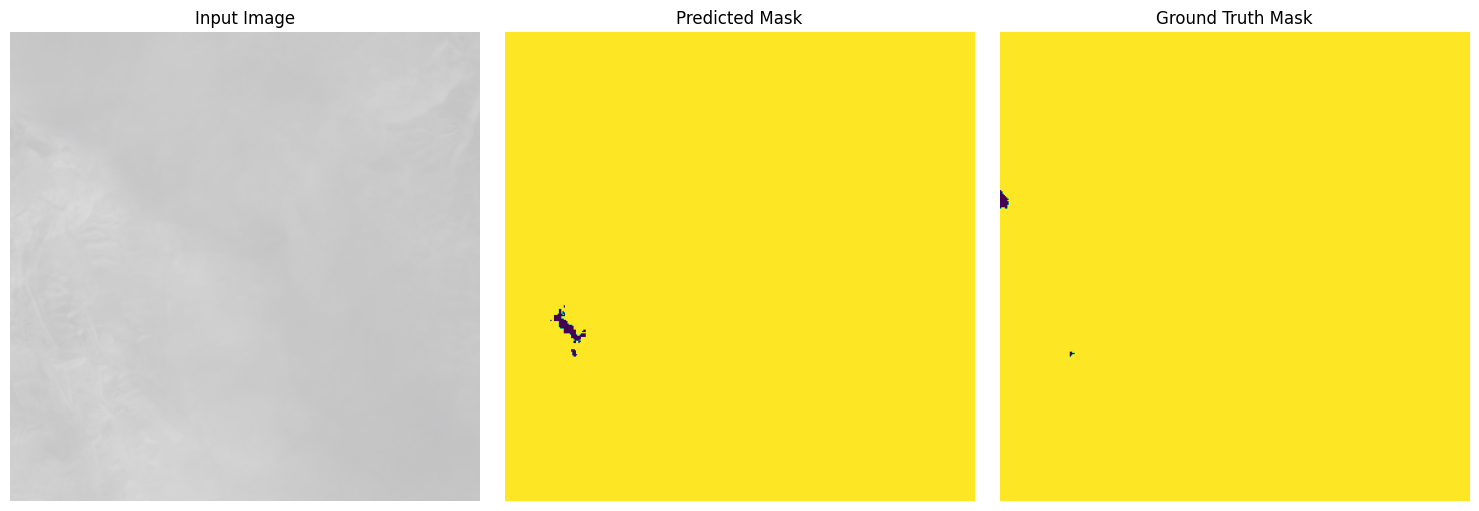

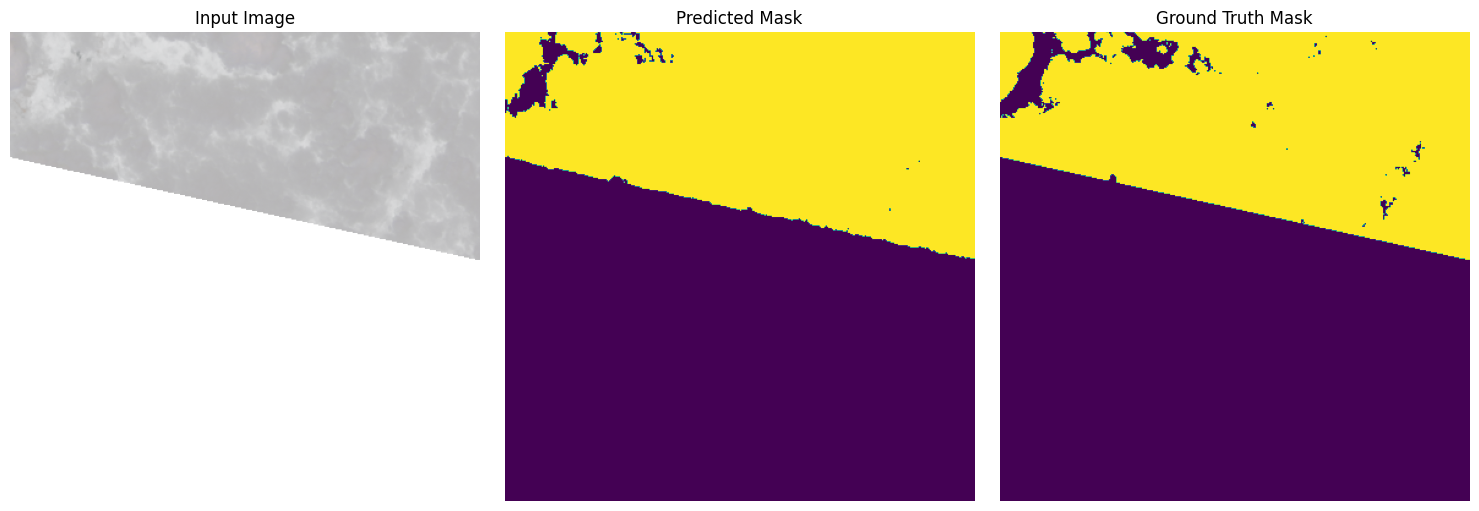

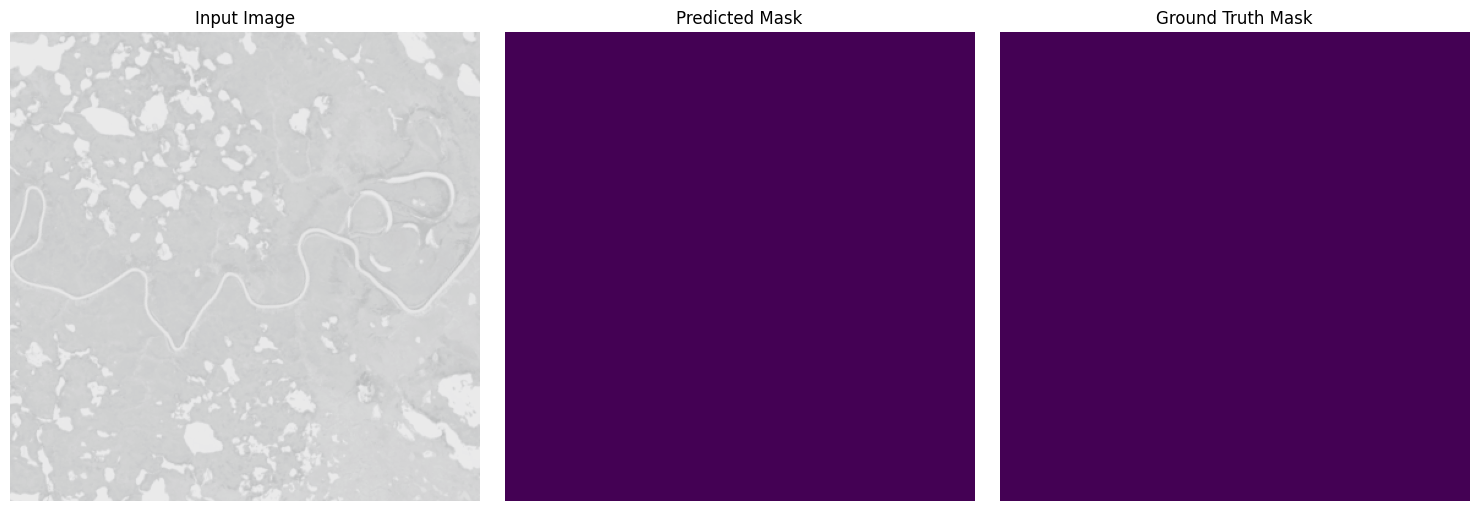

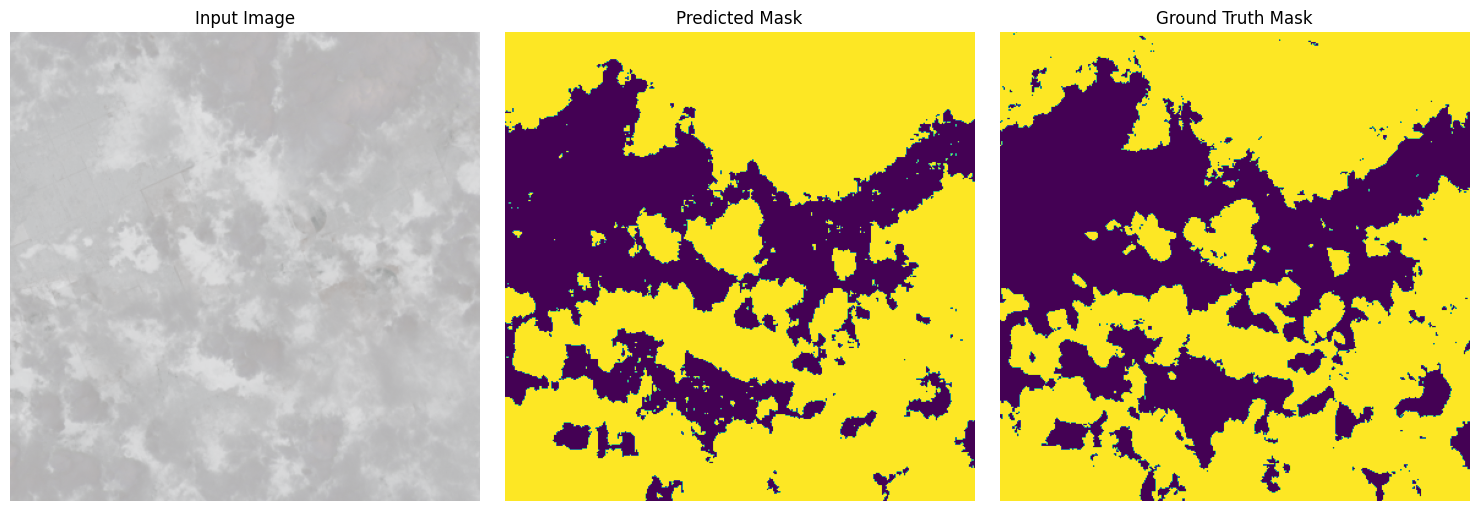

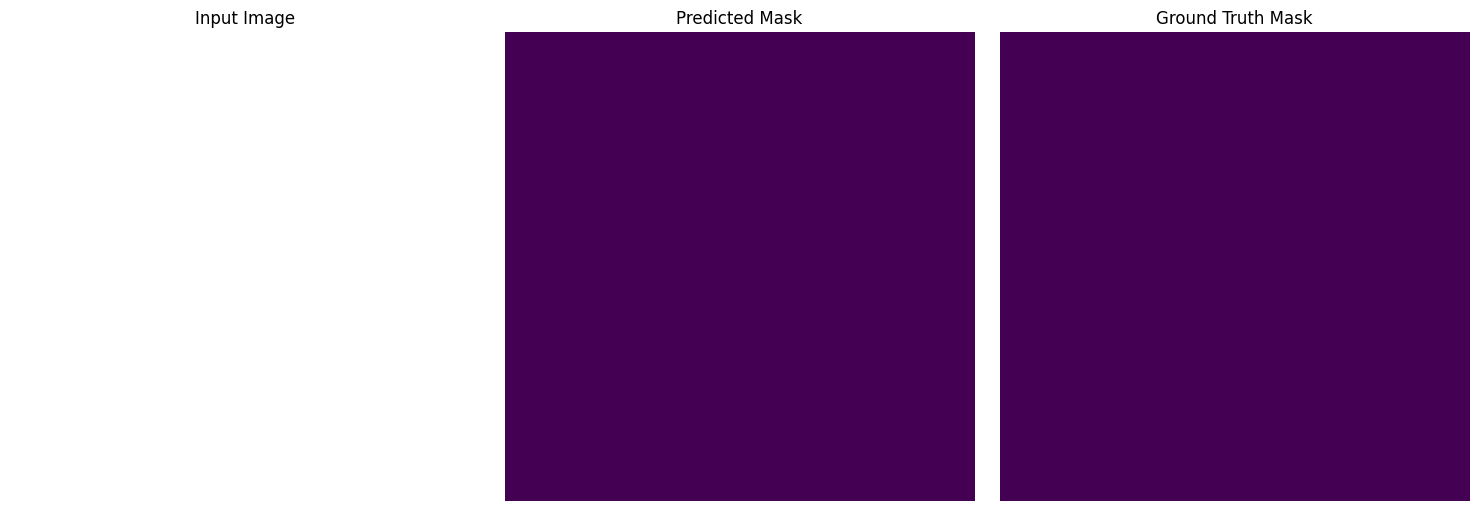

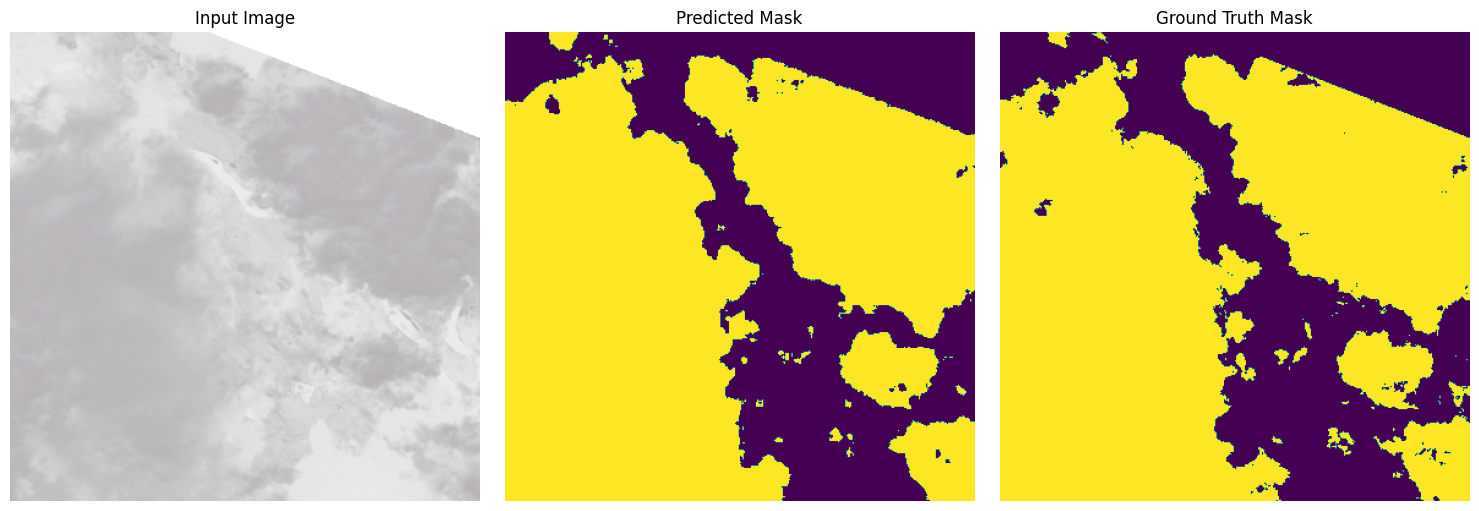

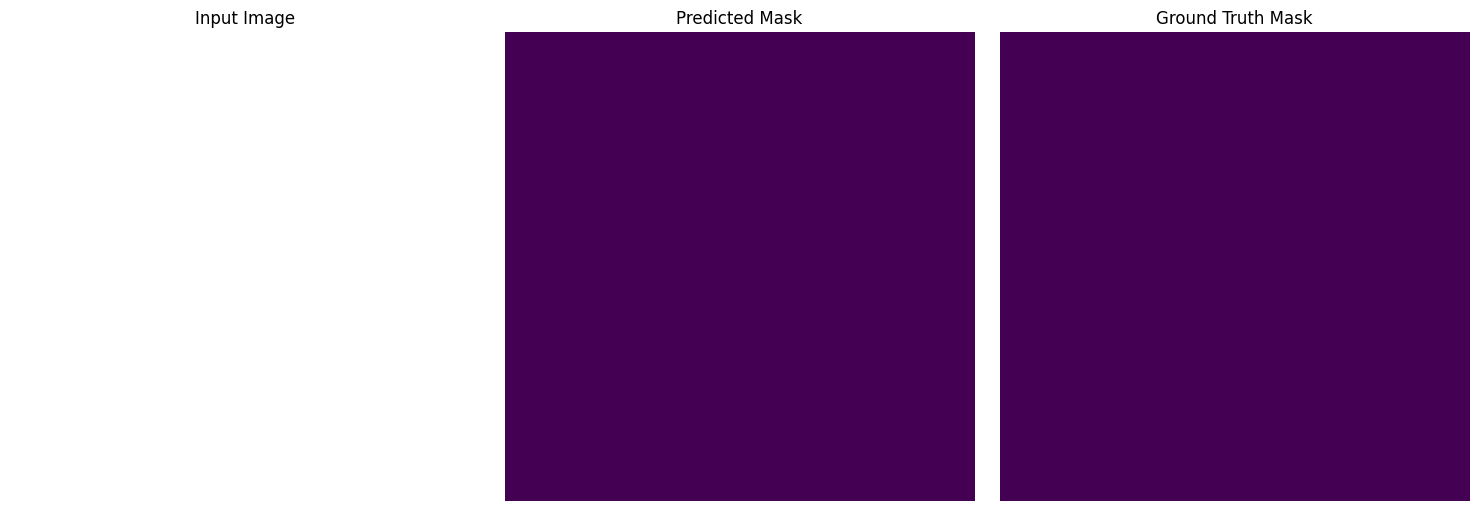

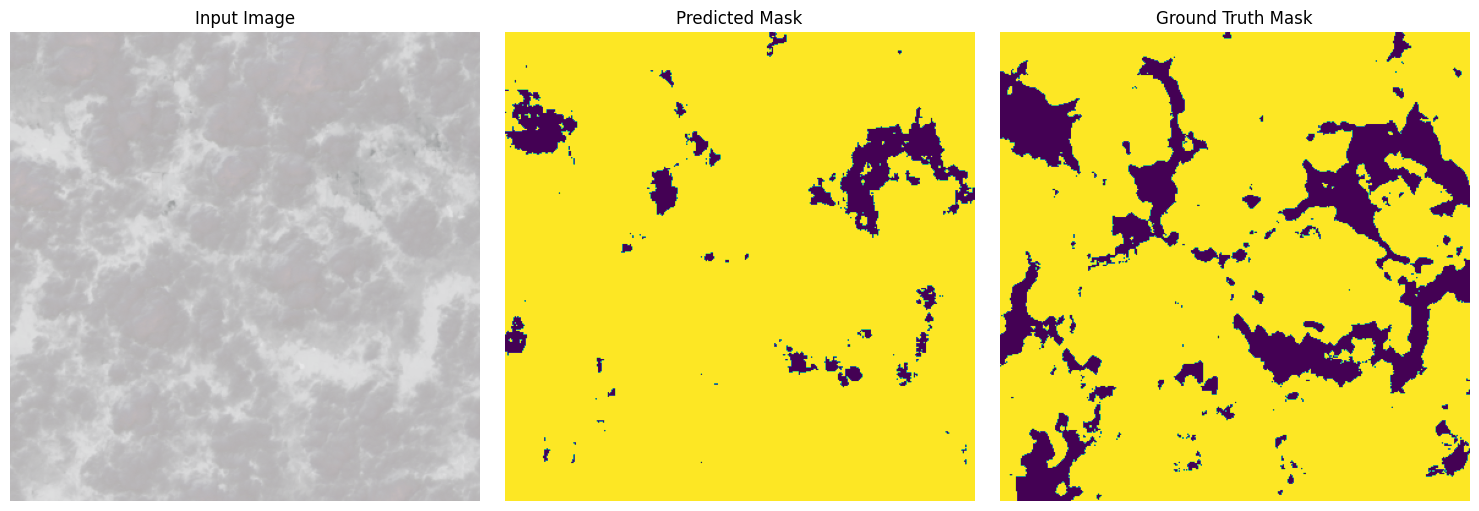

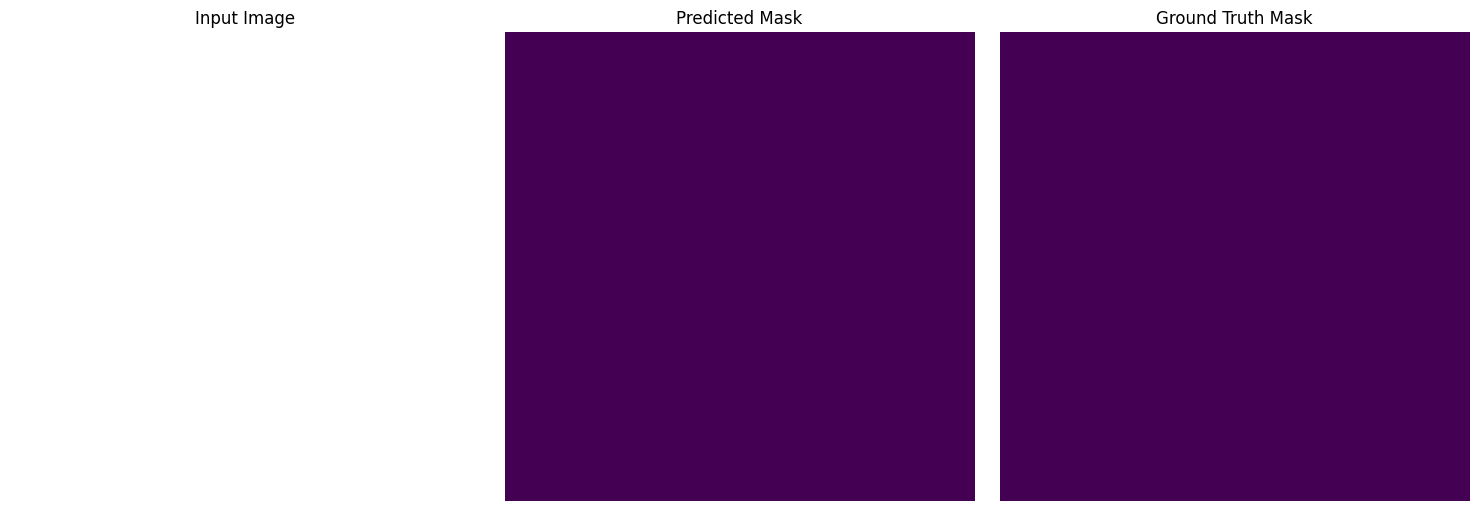

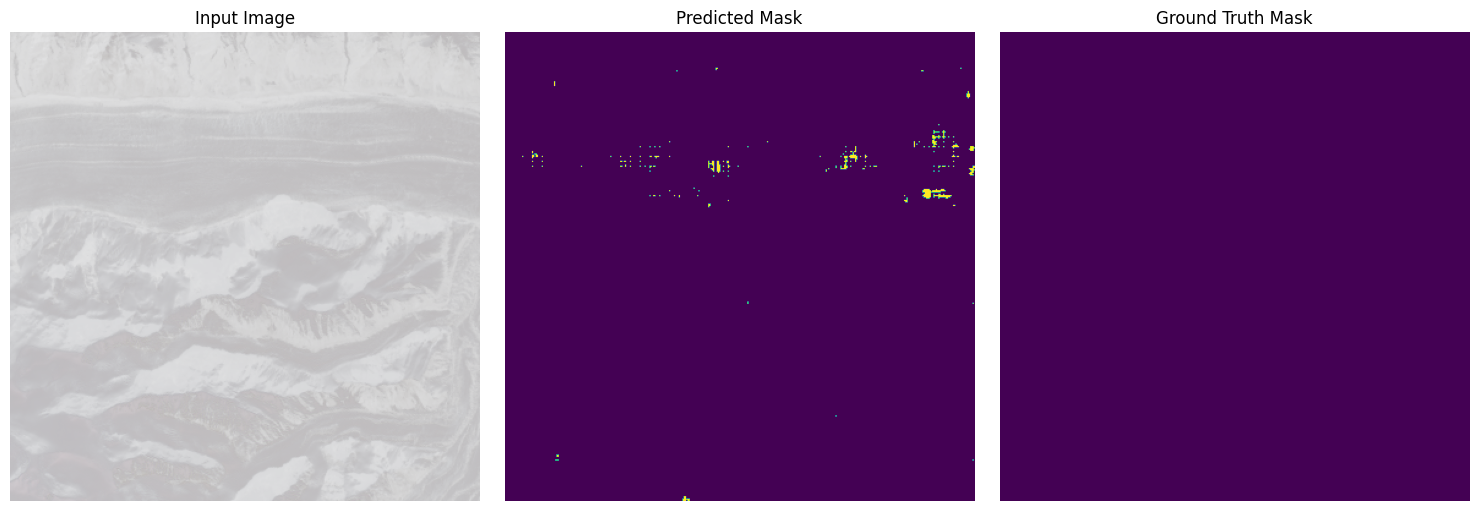

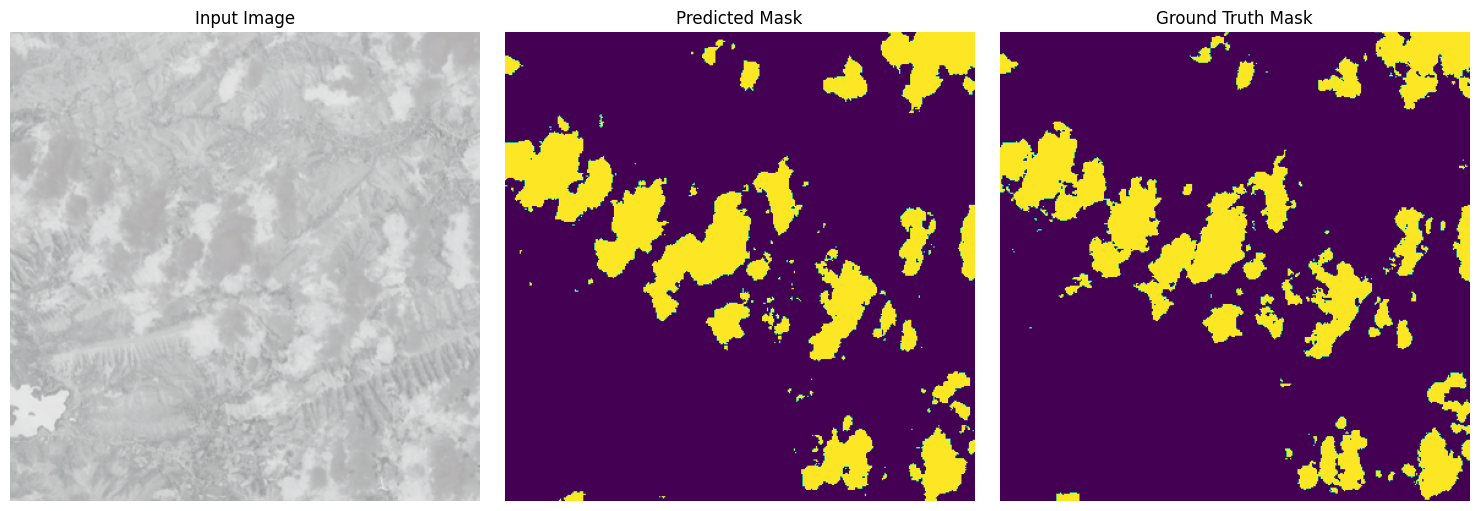

In [10]:
segnet_model.eval()

num_images_to_visualize = 40
images_visualized = 0

with torch.no_grad():
    for i, data in enumerate(valid_dl, 0):
        if images_visualized >= num_images_to_visualize:
            break  

        inputs, ground_truth = data

        # Move inputs to GPU
        inputs = inputs.to(device)
        
        # Insert into model
        outputs = segnet_model(inputs)

        _, predicted = torch.max(outputs, 1)
        
        # Convert tensors to numpy arrays for visualization
        input_images = inputs.cpu().numpy()
        output_masks = predicted.cpu().numpy()
        ground_truth_masks = ground_truth.numpy()  
        
        # Loop through images in the batch
        for idx in range(len(input_images)):
            input_image = np.transpose(input_images[idx], (1, 2, 0)) 
            input_image = (input_image * 255).astype(np.uint8)  
            
            output_mask = output_masks[idx]  
            gt_mask = ground_truth_masks[idx] 
            
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.title('Input Image')
            plt.imshow(input_image)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title('Predicted Mask')
            plt.imshow(output_mask, cmap='viridis')  
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title('Ground Truth Mask')
            plt.imshow(gt_mask, cmap='viridis')
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            
            images_visualized += 1
            if images_visualized >= num_images_to_visualize:
                break 
